In [2]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.3 MB/s eta 0:00:00


In [56]:
# pytorch 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import utils
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from transformers import PreTrainedTokenizerFast

# 시각화 관련
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm 
from tqdm.notebook import tqdm
from PIL import Image

# arange 기본
import numpy as np
import pandas as pd

# 그외
import os
import random
import tqdm
from glob import glob

In [4]:
USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


In [5]:
# 캐글 json으로 산타클로스 데이터 불러오기
from google.colab import files
!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# https://www.kaggle.com/datasets/deepcontractor/is-that-santa-image-classification
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

Saving kaggle.json to kaggle.json
 98% 200M/203M [00:07<00:00, 38.0MB/s]
100% 203M/203M [00:07<00:00, 29.6MB/s]


In [6]:
!unzip /content/is-that-santa-image-classification.zip

Archive:  /content/is-that-santa-image-classification.zip
  inflating: is that santa/test/not-a-santa/0.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/1.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/100.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/103.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/104.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/105.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/107.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/109.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/110.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/111.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/113.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/114.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/115.not-a-santa.jpg  
  inflating: is that santa/test/not-a-santa/116.not-a-santa.jpg  
  inflating: is that s

In [14]:
santa_imgs = ImageFolder('/content/is that santa/',
                         transform = transforms.Compose([
                             transforms.RandomCrop(80),
                             transforms.ToTensor()]))
train_loader = DataLoader(santa_imgs, batch_size = 1, shuffle = True)

In [15]:
santa_imgs[0][0].shape

torch.Size([3, 80, 80])

(3, 80, 80)


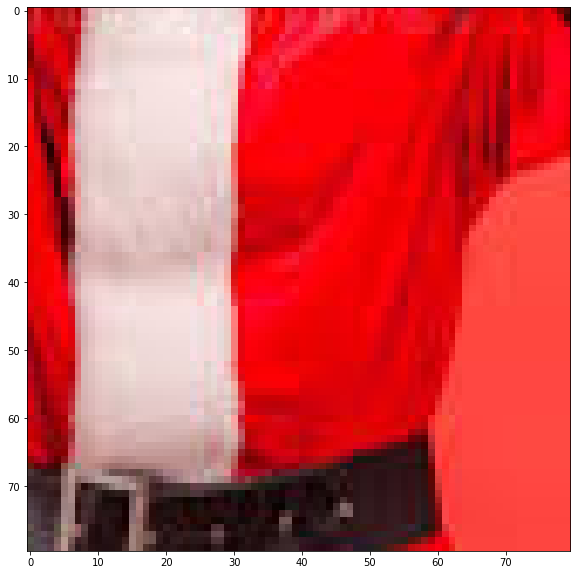

In [42]:
# 이 코드를 계속 실행하면 랜덤하게 cut되고 바껴요
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
print(npimg.shape)
plt.figure(figsize=(14, 10))
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()

# 노이즈를 더해봐요

In [28]:
imgfile = sorted(glob.glob(
    '/content/is that santa/train/santa/*.jpg'
))
imgfile[0]

'/content/is that santa/train/santa/10.Santa.jpg'

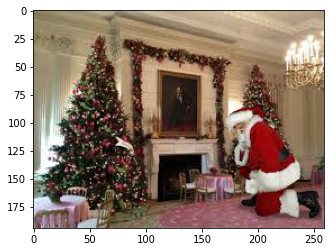

In [53]:
# image파일을 경로에 맞춰서 오픈할 수 있음
imageshow = Image.open(imgfile[1])
plt.imshow(imageshow)

In [34]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data = data_path
        self.label = [int(p.split('/')[-2] == 'santa') for p in data_path]
        self.data_len = len(self.data)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        image = Image.open(self.data[index], mode='r')
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        self.label[index] = np.array(self.label[index])
        return image, torch.from_numpy(self.label[index])

In [57]:
train_mother_path = '/content/is that santa/train/'
test_mother_path = '/content/is that santa/test/'

train_image_path = glob(os.path.join(train_mother_path, '*', '*'))
test_image_path = glob(os.path.join(test_mother_path, '*', '*'))

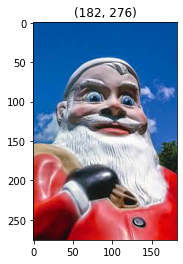

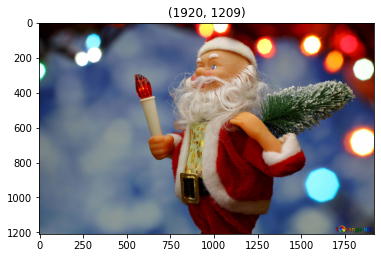

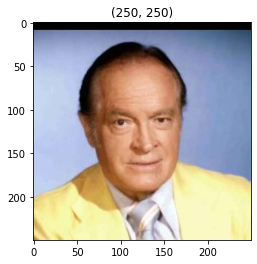

In [59]:
for _ in range(3):
    idx = np.random.randint(0, len(train_image_path))
    image = Image.open(train_image_path[idx])
    plt.imshow(image)
    plt.title(image.size)
    plt.show()

In [60]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [61]:
trainData = CustomDataset(train_image_path, transform=transform)
testData = CustomDataset(test_image_path, transform=transform)

In [62]:
BATCH_SIZE = 64

trainLoader = torch.utils.data.DataLoader(trainData,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testLoader = torch.utils.data.DataLoader(testData,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

In [63]:
def train(model, trainLoader):
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc

In [66]:
def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

In [67]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32),
                                    nn.MaxPool2d(kernel_size=3, stride=2)
                                    )
       
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.MaxPool2d(kernel_size=3, stride=2)
                                    )

        self.fc = nn.Linear(186624, 2)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [68]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)

In [69]:
%%time
# 시간체크 5분 예상
N_EPOCH = 5

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(cnn, trainLoader)
    val_loss, val_accuracy = test(cnn, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))
    

EPOCH 1
     Train | Loss :  1.1051, Accuracy :  77.20 %
Validation | Loss :  0.6048, Accuracy :  68.67 %

EPOCH 2
     Train | Loss :  0.3595, Accuracy :  93.32 %
Validation | Loss :  0.6553, Accuracy :  76.30 %

EPOCH 3
     Train | Loss :  0.1557, Accuracy :  96.42 %
Validation | Loss :  0.5279, Accuracy :  83.28 %

EPOCH 4
     Train | Loss :  0.0779, Accuracy :  97.23 %
Validation | Loss :  0.3562, Accuracy :  89.77 %

EPOCH 5
     Train | Loss :  0.0347, Accuracy :  98.70 %
Validation | Loss :  0.4729, Accuracy :  86.85 %

CPU times: user 1min 42s, sys: 1.48 s, total: 1min 44s
Wall time: 1min 50s


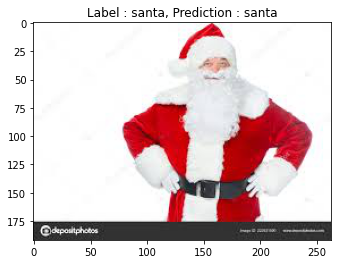

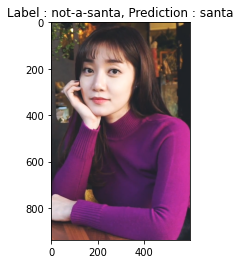

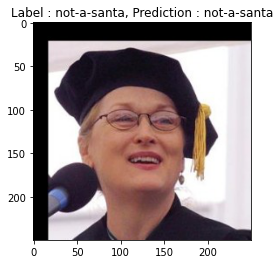

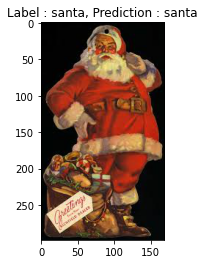

In [70]:
for _ in range(4):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]
    
    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)
    
    prediction = cnn(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    plt.imshow(image)
    plt.title(f'Label : {label}, Prediction : {pred_label}')
    plt.show()

In [71]:
!pip install ResNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ResNet: filename=resnet-0.1-py3-none-any.whl size=10044 sha256=89d1f731f3fad6c4161d7806ba5f2432656c4602b8b69a2b5811be90cfb6c42e
  Stored in directory: /root/.cache/pip/wheels/3c/db/ed/d285a3be8fa331aca2474dbd87b0e6c2ce5a9060f836723464
Successfully built ResNet


In [ ]:
# Use pretrained  
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet.fc.out_features = 2
googlenet = googlenet.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=1e-3)

In [ ]:
%%time
N_EPOCH = 5

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(googlenet, trainLoader)
    val_loss, val_accuracy = test(googlenet, testLoader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

In [ ]:
for _ in range(4):
    rnd_idx = np.random.randint(0, len(test_image_path))
    label = test_image_path[rnd_idx].split('/')[-2]
    image_path = test_image_path[rnd_idx]

    image = Image.open(image_path, mode='r')
    test_image = image.convert('RGB')
    test_image = transform(test_image)

    prediction = googlenet(torch.unsqueeze(test_image.to(device), 0))
    pred_label = 'santa' if torch.argmax(prediction, dim=1).item() == 1 else 'not-a-santa'
    
    plt.title(f'Label : {label}, Prediction : {pred_label}')
    plt.imshow(image)
    plt.show()